In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns 
import math
import statistics
import random

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from collections import Counter
from cmapPy.pandasGEXpress import parse as pe

# Functions

In [2]:
def load_data(path):
    """
    Loads the csv or csv.gz file into a pandas df, providing unique ID.
    """
    df = pd.read_csv(path)
    
    # Seperate data and metadata
    metadata_cols = [i for i in df.columns if 'Metadata' in i]
    metadata = df[metadata_cols]
    data_cols = [i for i in df.columns if i not in metadata_cols]
    
    # Remove exclude features from the data df
    data_cols = [x for x in data_cols if x.find('Costes')<0 if x.find('Manders')<0 if x.find('RWC')<0 
            if x.find('Parent')<0 if x.find('Object_Number')<0 if x.find('ObjectNumber')<0 if x.find('Children')<0]
    data = df[data_cols]
    
    # Use metadata to create the index
    metadata_df = metadata.copy()
    data_df = data.copy()
    metadata_df['my_id'] = metadata['Metadata_line_source'] + '_' + metadata['Metadata_line_condition'] + '_' + \
        metadata['Metadata_line_ID'].astype(str) + '_' + metadata['Metadata_well_position']
    data_df['my_id'] = metadata_df['my_id']
    data_df.set_index('my_id', inplace=True)
    print('df shape: {}'.format(data_df.shape))
    
#     Remove the extraneous 'control' or 'deletion' for the isogenic perturbs, to keep naming consistency.
    new_idx = data_df.index.tolist()
    new_idx = [i.split('_')[0]+'_'+ i.split('_')[1]+'_'+ i.split('_')[3]+'_' +i.split('_')[4] \
               if 'genic' in i else i for i in new_idx]
    
    data_df.index = new_idx
    return data_df

In [3]:
def var_threshold_selection(data, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def corr_threshold_selection(df, threshold):
    corr = df.corr(method='spearman')
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= threshold:
                if columns[j]:
                    columns[j] = False
    selected_columns = df.columns[columns]
    selected_data = df[selected_columns]
    return selected_data

In [4]:
def plot_corr_matrix(df, return_corrs=True):
    corrs = df.corr(method='spearman')
    size = df.shape[1]
    fig, ax = plt.subplots(figsize=(size/4,size/5)) 
    sns.heatmap(corrs, cmap='coolwarm', ax=ax)
    
    vals = list(np.triu(corrs, k=1).flatten())
    vals = [i for i in vals if i != 0]
    mean_corr = sum(vals)/len(vals)
    stdev_corr = statistics.stdev(vals)
    print('Number of features: {}'.format(df.shape))
    print ('Mean corr: {}, Stdev corr: {}'.format(mean_corr, stdev_corr))
    if return_corrs:
        return corrs
    else: pass
    
def get_corr_between_compartments(metafeature_df):
    cells_df = metafeature_df.T[metafeature_df.T.index.str.startswith('Cells')]
    cyto_df = metafeature_df.T[metafeature_df.T.index.str.startswith('Cytoplasm')]
    nuc_df = metafeature_df.T[metafeature_df.T.index.str.startswith('Nuclei')]
    cells_vals = cells_df.values.flatten().tolist()
    nyto_vals = cyto_df.values.flatten().tolist()
    nuc_vals = nuc_df.values.flatten().tolist()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14, 4))
    ax1.scatter(cells_vals, cyto_vals)
    ax2.scatter(cells_vals, nuc_vals)
    ax3.scatter(cyto_vals, nuc_vals)
    print('R2 scores: {}, {}, {}'.format(r2_score(cells_vals, cyto_vals),
                                        r2_score(cells_vals, nuc_vals),
                                        r2_score(cyto_vals, nuc_vals)))

# Stdev Selection

In [5]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized.csv.gz')
data_by_well = data_by_well.dropna(axis=1, how='any')
data_by_well = var_threshold_selection(data_by_well, threshold=0.01)
data_by_well.shape

df shape: (384, 4008)


(384, 3967)

In [6]:
data_by_well['group'] = data_by_well.index.str.split('_').map(lambda x: x[2])

# Remove high stdev features
# For each feature, get mean standrad dev
perturb_list = list(set(data_by_well['group'].tolist()))
feature_list = data_by_well.drop('group', axis=1).columns.tolist()
features_std_to_keep = []

keep_threshold = 0.8 # 1 percent percentile of null
mean_stdevs = []

for feature in feature_list:
    feature_stdevs = [] # list of stdevs per feature, should equal number of perturbations
    for perturb in perturb_list:
        temp = data_by_well[data_by_well['group'] == perturb][feature]
        temp_values = list(temp.values)
        feature_stdevs.append(np.std(temp_values))
    feature_mean_stdev = np.mean(feature_stdevs)
    mean_stdevs.append(feature_mean_stdev)
    if feature_mean_stdev < keep_threshold:
        features_std_to_keep.append(feature)
    # Reset feature stdevs for the next feature
    feature_stdevs = []
    
print(len(features_std_to_keep))

3471


In [7]:
# Null distribution for stdev features
perturb_list = list(set(data_by_well['group'].tolist()))
feature_list = data_by_well.drop('group', axis=1).columns.tolist()

# Shuffle the groups
groups = data_by_well['group'].tolist()
random.Random(4).shuffle(groups)
data_by_well['group'] = groups

mean_stdevs_null = []
for feature in feature_list:
    feature_stdevs = [] # list of stdevs per feature, should equal number of perturbations
    for perturb in perturb_list:
        temp = data_by_well[data_by_well['group'] == perturb][feature]
        temp_values = list(temp.values)
        feature_stdevs.append(np.std(temp_values))
    feature_mean_stdev = np.mean(feature_stdevs)
    mean_stdevs_null.append(feature_mean_stdev)
    # Reset feature stdevs for the next feature
    feature_stdevs = []

0.7966286888190297


C:\Users\Ruifan\anaconda3\envs\cytominer\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ruifan\anaconda3\envs\cytominer\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Mean Standard Deviation by Feature')

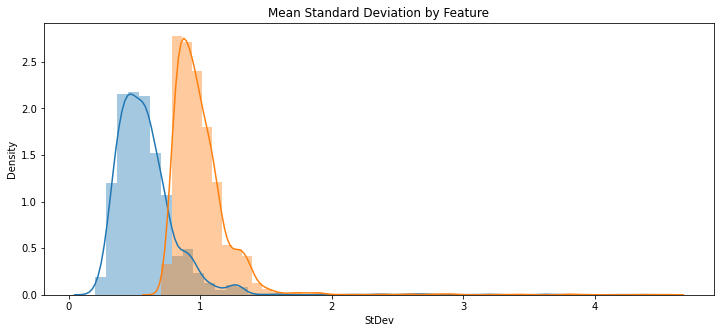

In [8]:
print(np.percentile(mean_stdevs_null, 5))
# distplot of the mean stdevs for each feature
fig, ax = plt.subplots(figsize=(12,5))
sns.distplot(mean_stdevs, ax=ax)
sns.distplot(mean_stdevs_null, ax=ax)
plt.xlabel('StDev')

plt.title('Mean Standard Deviation by Feature')


In [42]:
data_stdev_fs = data_by_well[features_std_to_keep]
data_stdev_fs.shape

(384, 3471)

# Group features and apply corr threshold

In [50]:
# For a given feature name, get the grouped names
cat1 = ['Cells_AreaShape', 'Cytoplasm_AreaShape', 'Nuclei_AreaShape',
       'Cells_Neighbors', 'Cytoplasm_Neighbors', 'Nuclei_Neighbors',
       'Cells_Correlation', 'Cytoplasm_Correlation', 'Nuclei_Correlation']
cat2 = ['Location', 'Granularity', 'Texture', 'Intensity', 'RadialDistribution']

def get_group_feature_names(df, name_pruning_categories1, name_pruning_categories2):
    """
    features_df: the df of significant features with their values for a given gene or cluster
    categories1 is the AreaShape features ['Cells_AreaShape', 'Cells_Mean_A568Objects_AreaShape', 'Cells_Mean_Tubes_AreaShape', 
                           'Cytoplasm_AreaShape', 'Nuclei_AreaShape']
    categories2 is the other features ['Location', 'Granularity', 'Texture', 'Intensity', 'RadialDistribution']
    """
    if 'cluster_num' in df.columns:
        df = df.drop(['cluster_num'], axis=1)
    df = df.T
    df['split'] = df.index.str.split('_')
    df['group'] = ''
    channels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'Brightfield']
    # Categorize the AreaShape features
    for index, row in df.iterrows():
#         print(index)
        for name in name_pruning_categories1:
            if name in index:
                df.loc[index, 'group'] = name
        for name in name_pruning_categories2:
            for ch in channels:
                if name in row['split'] and ch in index[-30:]:
                    df.loc[index, 'group'] = name + '_' + ch

    return df

In [51]:
data_grouped = get_group_feature_names(data_stdev_fs, cat1, cat2)
set(data_grouped['group'].tolist())

{'Cells_AreaShape',
 'Cells_Correlation',
 'Cells_Neighbors',
 'Cytoplasm_AreaShape',
 'Cytoplasm_Correlation',
 'Granularity_AGP',
 'Granularity_Brightfield',
 'Granularity_DNA',
 'Granularity_ER',
 'Granularity_Mito',
 'Granularity_RNA',
 'Intensity_AGP',
 'Intensity_Brightfield',
 'Intensity_DNA',
 'Intensity_ER',
 'Intensity_Mito',
 'Intensity_RNA',
 'Location_AGP',
 'Location_Brightfield',
 'Location_DNA',
 'Location_ER',
 'Location_Mito',
 'Location_RNA',
 'Nuclei_AreaShape',
 'Nuclei_Correlation',
 'Nuclei_Neighbors',
 'RadialDistribution_AGP',
 'RadialDistribution_Brightfield',
 'RadialDistribution_DNA',
 'RadialDistribution_ER',
 'RadialDistribution_Mito',
 'RadialDistribution_RNA',
 'Texture_AGP',
 'Texture_Brightfield',
 'Texture_DNA',
 'Texture_ER',
 'Texture_Mito',
 'Texture_RNA'}

In [26]:
groups = data_grouped['group']
data_annotated = data_stdev_fs.copy()
data_annotated.loc['metafeature'] = groups

In [39]:
# all tables
cells_AS = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Cells_AreaShape']].drop(['metafeature'], axis=0).astype('float64')
cyto_AS = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Cytoplasm_AreaShape']].drop(['metafeature'], axis=0).astype('float64')
nuc_AS = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Nuclei_AreaShape']].drop(['metafeature'], axis=0).astype('float64')

cells_corr = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Cells_Correlation']].drop(['metafeature'], axis=0).astype('float64')
cyto_corr = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Cytoplcorrm_Correlation']].drop(['metafeature'], axis=0).astype('float64')
nuc_corr = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Nuclei_Correlation']].drop(['metafeature'], axis=0).astype('float64')

cells_neighbors = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Cells_Neighbors']].drop(['metafeature'], axis=0).astype('float64')
cyto_neighbors = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Cytoplcorrm_Neighbors']].drop(['metafeature'], axis=0).astype('float64')
nuc_neighbors = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Nuclei_Neighbors']].drop(['metafeature'], axis=0).astype('float64')

agp_loc = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Location_AGP']].drop(['metafeature'], axis=0).astype('float64')
agp_gran = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Granularity_AGP']].drop(['metafeature'], axis=0).astype('float64')
agp_tex = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Texture_AGP']].drop(['metafeature'], axis=0).astype('float64')
agp_int = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Intensity_AGP']].drop(['metafeature'], axis=0).astype('float64')
agp_rdist = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='RadialDistribution_AGP']].drop(['metafeature'], axis=0).astype('float64')

Brightfield_loc = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Location_Brightfield']].drop(['metafeature'], axis=0).astype('float64')
Brightfield_gran = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Granularity_Brightfield']].drop(['metafeature'], axis=0).astype('float64')
Brightfield_tex = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Texture_Brightfield']].drop(['metafeature'], axis=0).astype('float64')
Brightfield_int = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Intensity_Brightfield']].drop(['metafeature'], axis=0).astype('float64')
Brightfield_rdist = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='RadialDistribution_Brightfield']].drop(['metafeature'], axis=0).astype('float64')

dna_loc = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Location_DNA']].drop(['metafeature'], axis=0).astype('float64')
dna_gran = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Granularity_DNA']].drop(['metafeature'], axis=0).astype('float64')
dna_tex = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Texture_DNA']].drop(['metafeature'], axis=0).astype('float64')
dna_int = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Intensity_DNA']].drop(['metafeature'], axis=0).astype('float64')
dna_rdist = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='RadialDistribution_DNA']].drop(['metafeature'], axis=0).astype('float64')

ER_loc = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Location_ER']].drop(['metafeature'], axis=0).astype('float64')
ER_gran = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Granularity_ER']].drop(['metafeature'], axis=0).astype('float64')
ER_tex = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Texture_ER']].drop(['metafeature'], axis=0).astype('float64')
ER_int = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Intensity_ER']].drop(['metafeature'], axis=0).astype('float64')
ER_rdist = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='RadialDistribution_ER']].drop(['metafeature'], axis=0).astype('float64')

Mito_loc = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Location_Mito']].drop(['metafeature'], axis=0).astype('float64')
Mito_gran = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Granularity_Mito']].drop(['metafeature'], axis=0).astype('float64')
Mito_tex = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Texture_Mito']].drop(['metafeature'], axis=0).astype('float64')
Mito_int = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Intensity_Mito']].drop(['metafeature'], axis=0).astype('float64')
Mito_rdist = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='RadialDistribution_Mito']].drop(['metafeature'], axis=0).astype('float64')

RNA_loc = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Location_RNA']].drop(['metafeature'], axis=0).astype('float64')
RNA_gran = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Granularity_RNA']].drop(['metafeature'], axis=0).astype('float64')
RNA_tex = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Texture_RNA']].drop(['metafeature'], axis=0).astype('float64')
RNA_int = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='Intensity_RNA']].drop(['metafeature'], axis=0).astype('float64')
RNA_rdist = data_annotated[data_annotated.columns[data_annotated.loc['metafeature']=='RadialDistribution_RNA']].drop(['metafeature'], axis=0).astype('float64')


In [40]:
tables = [cells_AS, cyto_AS, nuc_AS,
         cells_neighbors, cyto_neighbors, nuc_neighbors,
         cells_corr, cyto_corr, nuc_corr,
         agp_loc, agp_gran, agp_tex, agp_int, agp_rdist,
         Brightfield_loc,Brightfield_gran, Brightfield_tex, Brightfield_int, Brightfield_rdist,
         dna_loc, dna_gran, dna_tex, dna_int, dna_rdist,
         ER_loc, ER_gran, ER_tex, ER_int, ER_rdist,
         Mito_loc,Mito_gran, Mito_tex, Mito_int, Mito_rdist,
         RNA_loc, RNA_gran, RNA_tex, RNA_int, RNA_rdist]
ct = 0
for i in tables:
    ct+= i.shape[1]    
ct


3414

In [56]:
feature_selected = pd.DataFrame(index=data_stdev_fs.index)

for i in tables:
    corr_selected = corr_threshold_selection(i, 0.9)
    feature_selected = pd.concat([feature_selected, corr_selected], axis=1)

feature_selected

,Cells_AreaShape_Area,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaximumRadius,Cells_AreaShape_Zernike_1_1,...,Cytoplasm_RadialDistribution_RadialCV_RNA_4of4,Nuclei_RadialDistribution_FracAtD_RNA_1of4,Nuclei_RadialDistribution_FracAtD_RNA_3of4,Nuclei_RadialDistribution_FracAtD_RNA_4of4,Nuclei_RadialDistribution_MeanFrac_RNA_1of4,Nuclei_RadialDistribution_MeanFrac_RNA_3of4,Nuclei_RadialDistribution_MeanFrac_RNA_4of4,Nuclei_RadialDistribution_RadialCV_RNA_1of4,Nuclei_RadialDistribution_RadialCV_RNA_3of4,Nuclei_RadialDistribution_RadialCV_RNA_4of4
human_control_1_A01,-0.14892,1.130900,0.005548,-1.40540,0.389780,0.74381,0.68491,-0.27560,0.42848,0.62864,...,0.63067,0.193040,0.77210,-0.49253,-0.04466,0.39333,-0.086857,-0.461250,0.17229,0.80285
human_control_1_A02,-0.03620,-1.200800,-0.484760,-1.18670,-0.011431,0.98623,0.87631,-0.37582,0.54565,0.29320,...,0.41160,0.283530,0.97443,-0.65826,1.22080,1.81430,-1.629800,0.186760,0.58600,0.79696
human_deletion_30_A03,-0.96630,0.204610,-0.841970,-1.15040,0.124140,1.30120,1.45180,-1.13700,-0.45902,-0.43084,...,0.35295,0.362790,0.24090,-0.26694,-0.23375,-0.69550,0.585520,0.056124,0.83412,1.07440
human_deletion_30_A04,-1.37960,-0.047341,-1.075100,-1.27500,-0.325320,1.23400,1.25640,-1.60640,-1.13000,-0.13169,...,-0.09305,0.055469,-0.13592,0.15675,0.06204,-0.59298,0.325020,0.411830,0.93249,0.92898
human_control_9_A05,-1.45620,-1.288700,-0.077312,-1.33970,1.306600,0.86106,0.91191,-1.24910,-0.99232,1.07050,...,0.92313,1.047100,1.69690,-1.64480,-1.58890,-1.35140,2.021200,-0.620430,2.25470,3.18650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
human_control_13_P20,-0.58287,1.834700,-0.159720,-0.27484,1.307400,0.22612,-1.07700,-0.66678,-0.32296,1.58530,...,1.18560,0.164550,1.36600,-0.84927,-1.02590,-0.27215,1.041400,-1.620500,-1.23230,0.64450
human_deletion_35_P21,3.68770,1.035200,2.715000,1.57760,1.289800,-2.31310,-2.33460,3.50310,1.34320,-0.94244,...,1.31670,-2.050000,0.37682,1.46580,-2.06420,0.45309,1.402000,-1.822100,-0.55387,1.14540
human_deletion_35_P22,4.44180,0.972280,1.995600,0.93338,1.130300,-1.43130,-1.88650,3.31400,2.12850,0.98889,...,1.61830,-2.577900,-0.21853,2.23130,-2.15570,0.28141,1.420800,-1.660800,-0.11610,1.48770
human_control_22_P23,-0.58802,2.608200,0.657390,0.63520,1.190700,-0.82908,-1.83630,-0.12455,-0.59209,0.84655,...,0.83531,0.001526,1.36770,-0.71594,-1.57250,-0.72866,1.702400,-1.965100,-1.97680,0.61217


In [57]:
# feature_selected.to_csv('C:/Users/Ruifan/neuronal-cell-painting/feature_sets/STEM01/0621_stdev_corr_fs.csv')